<a href="https://colab.research.google.com/github/asimbash/PC-based-loss-model/blob/master/demoTrainAndTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [9]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/data_asim3')

First we will extract the frames from the videos.

In [12]:
#This will extract our frames from the videos and save them in the same folder 
#as the test and train videos. Also it will create a .csv file which contains 
#information about each video, as in name, label, number of frames per video.

import csv
import glob
import os.path
from subprocess import call
import os

def extract_files():
    data_file = []
    folders = ['train','test']
    print(folders)
    for folder in folders:
        class_folders = glob.glob(os.path.join(folder, '*'))
        print('Asim was here')
        print(class_folders)
        for vid_class in class_folders:
            print(vid_class)
            class_files = glob.glob(os.path.join(vid_class, '*.avi'))
            print(class_files)

            for video_path in class_files:
                # Get the parts of the file.
                video_parts = get_video_parts(video_path)

                train_or_test, classname, filename_no_ext, filename = video_parts

                # Only extract if we haven't done it yet. Otherwise, just get
                # the info.
                if not check_already_extracted(video_parts):
                    # Now extract it.
                    src = os.path.join(train_or_test, classname, filename)
                    dest = os.path.join(train_or_test, classname,
                        filename_no_ext + '-%04d.jpg')
                    call(["ffmpeg", "-i", src, dest])

                # Now get how many frames it is.
                nb_frames = get_nb_frames_for_video(video_parts)

                data_file.append([train_or_test, classname, filename_no_ext, nb_frames])

                #print("Generated %d frames for %s" % (nb_frames, filename_no_ext))

    with open('data_file.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerows(data_file)
    #[train|test], class, filename, nb frames
    print("Extracted and wrote %d video files." % (len(data_file)))

def get_nb_frames_for_video(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(os.path.join(train_or_test, classname,
                                filename_no_ext + '*.jpg'))
    return len(generated_files)

def get_video_parts(video_path):
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

def check_already_extracted(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    return bool(os.path.exists(os.path.join(train_or_test, classname,
                               filename_no_ext + '-0001.jpg')))

#Use the above function to extract the frames.
extract_files()

['train', 'test']
Asim was here
['train/RopeClimbing', 'train/BreastStroke', 'train/JumpingJack', 'train/Crawling']
train/RopeClimbing
['train/RopeClimbing/v_RopeClimbing_g16_c04.avi', 'train/RopeClimbing/v_RopeClimbing_g16_c05.avi', 'train/RopeClimbing/v_RopeClimbing_g17_c01.avi', 'train/RopeClimbing/v_RopeClimbing_g17_c02.avi', 'train/RopeClimbing/v_RopeClimbing_g17_c03.avi', 'train/RopeClimbing/v_RopeClimbing_g17_c04.avi', 'train/RopeClimbing/v_RopeClimbing_g17_c05.avi', 'train/RopeClimbing/v_RopeClimbing_g18_c01.avi', 'train/RopeClimbing/v_RopeClimbing_g18_c02.avi', 'train/RopeClimbing/v_RopeClimbing_g18_c03.avi', 'train/RopeClimbing/v_RopeClimbing_g18_c04.avi', 'train/RopeClimbing/v_RopeClimbing_g18_c05.avi', 'train/RopeClimbing/v_RopeClimbing_g19_c01.avi', 'train/RopeClimbing/v_RopeClimbing_g19_c02.avi', 'train/RopeClimbing/v_RopeClimbing_g19_c03.avi', 'train/RopeClimbing/v_RopeClimbing_g19_c04.avi', 'train/RopeClimbing/v_RopeClimbing_g19_c05.avi', 'train/RopeClimbing/v_RopeClimb

Now we will create a data generator. An object named DataSet is created with the required attributes

In [14]:
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading

from keras.utils import to_categorical
class DataSet():

    def __init__(self, seq_length=40, class_limit=None, image_shape=(224, 224, 3)):
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('data_asim3', 'sequences')
        self.max_frames = 300  # max number of frames a video can have for us to use it
        self.data = self.get_data()
        self.classes = self.get_classes()
        self.data = self.clean_data()
        self.image_shape = image_shape

    @staticmethod
    def get_data():
        with open(os.path.join('data_asim3', 'data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)
        return data

    def clean_data(self):
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.seq_length and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])
        classes = sorted(classes)
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        # Encode it first.
        label_encoded = self.classes.index(class_str)
        # Now one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))
        assert len(label_hot) == len(self.classes)
        return label_hot

    def split_train_test(self):
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        for row in data:
            sequence = self.get_extracted_sequence(data_type, row)
            if sequence is None:
                print("Can't find sequence. Did you generate them?")
                raise
            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))
        return np.array(X), np.array(y)

    def get_extracted_sequence(self, data_type, sample):
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)
        sequence = self.get_extracted_sequence(data_type, sample)
        if sequence is None:
            raise ValueError("Can't find sequence. Did you generate them?")
        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join('data_asim3', sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def rescale_list(input_list, size):
        assert len(input_list) >= size
        skip = len(input_list) // size
        output = [input_list[i] for i in range(0, len(input_list), skip)]
        return output[:size]

In [19]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

Now we will load the pretrained CNN as base model for feature extraction and also generate the sequence data from the frames in the form of numpy tensors

In [21]:
import numpy as np
import os.path
from keras.preprocessing import image as Img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
from tqdm import tqdm

# Get the dataset.
data = DataSet(seq_length=40, class_limit=70)

#Base model
base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)
# We'll extract features at the final pool layer.
model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)

# Loop through data.
pbar = tqdm(total=len(data.data))
for video in data.data:

    # Get the path to the sequence for this video.
    path = os.path.join('data_asim3', 'sequences', video[2] + '-' + str(data.seq_length) + \
        '-features')  # numpy will auto-append .npy
    # Check if we already have it.
    if os.path.isfile(path + '.npy'):
        pbar.update(1)
        continue

    # Get the frames for this video.
    frames = data.get_frames_for_sample(video)
    #print(frames)

    # Now downsample to just the ones we need.
    frames = data.rescale_list(frames, 40)
    #print(frames)
    #extracting features and appending to build the sequence.
    sequence = []
    for image in frames:
        img = Img.load_img(image, target_size=(299, 299))
        x = Img.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        sequence.append(features[0])
        #print(sequence)

    # Save the sequence.
    np.save(path, sequence)

    pbar.update(1)

pbar.close()


100%|██████████| 460/460 [1:22:57<00:00, 10.82s/it]


Now we will create checkpoints wherein we will save the models when ever there is increase in the performance.

In [26]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from collections import deque
import sys
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
import os.path
checkpointer = ModelCheckpoint(
    filepath=os.path.join('data_asim3', 'checkpoints','lstm-features' + '.{epoch:03d}-{val_loss:.3f}.hdf5'),
    verbose=1,
    save_best_only=True)



In [27]:
# Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('data_asim3', 'logs', 'lstm'))

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('data_asim3', 'logs', 'lstm' + '-' + 'training-' + \
    str(timestamp) + '.log'))



In [29]:
X, y = data.get_all_sequences_in_memory('train', 'features')
X_test, y_test = data.get_all_sequences_in_memory('test', 'features')   

Loading 330 samples into memory for training.
Loading 130 samples into memory for testing.


Now we will load the LSTM model and train it on our dataset

In [30]:
model = Sequential()
model.add(LSTM(2048, return_sequences=False,input_shape=(40,2048),dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(data.classes), activation='softmax'))
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                    metrics=['accuracy','top_k_categorical_accuracy'])
print(model.summary())

history = model.fit(X,
                    y,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[tb, early_stopper, csv_logger,checkpointer],
                    epochs=30)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2048)              33562624  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 34,613,764
Trainable params: 34,613,764
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
11/11 [==============================] - 4s 225ms/step - loss: 1.3956 - accuracy: 0.2864 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.0607 - val_accuracy: 0.8000 - val_top_k_categorical_accuracy: 1.0000

Epoch 00001: val

Now plot the results

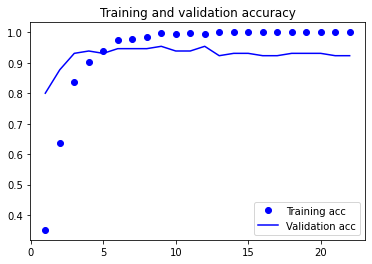

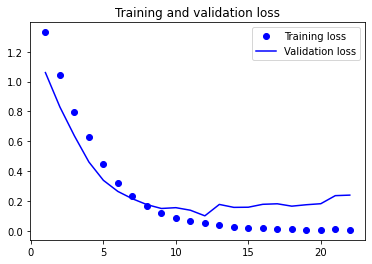

In [31]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()